## In order to use Yolo, we need to perform several pre-processing steps. 

1. Given the training csv, we will need to conevrt the labels for each box from COCO format to yolo format. 

2. Create a .txt file with all annotations for each image. One line per box and a class identifier

3. Create a blank .txt for the images without boxes.



In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from ast import literal_eval
import cv2
import matplotlib.pyplot as plt

In [17]:
path = "C:/Users/IVCL/Desktop/crane"
image_dir = path + "/real_image"
image_list = os.listdir(image_dir)
train_df = pd.read_csv("C:/Users/IVCL/Desktop/crane/bbox_real.csv")

In [18]:
train_df.head()

,xl,yl,xr,yr
0,160,168,601,528
1,171,149,521,492
2,120,132,509,497
3,31,142,462,483
4,130,92,512,519


In [19]:
image_list[0][:-4]

'creal_0001'

In [20]:
train_df['bbox'] = [[train_df['yl'][i], train_df['xl'][i], train_df['yr'][i]-train_df['yl'][i],
                     train_df['xr'][i]-train_df['xl'][i]] for i in range(0,len(train_df))]
train_df['image_id'] = [image[:-4] for image in image_list]

In [21]:
train_df.head()

,xl,yl,xr,yr,bbox,image_id
0,160,168,601,528,"[168, 160, 360, 441]",creal_0001
1,171,149,521,492,"[149, 171, 343, 350]",creal_0002
2,120,132,509,497,"[132, 120, 365, 389]",creal_0003
3,31,142,462,483,"[142, 31, 341, 431]",creal_0004
4,130,92,512,519,"[92, 130, 427, 382]",creal_0005


* The bounding box format as given is [xmin, ymin, widht, height] in pixels. For yolov4, we have to convert these labels into Yolo format. Below is how to do so. 

In [22]:
def convert(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def convert_to_yolo_label(bbox, w = 720, h = 720):
    xmin = bbox[0]
    xmax = bbox[0] + bbox[2]
    ymin = bbox[1]
    ymax = bbox[1] + bbox[3]
    b = (float(xmin), float(xmax), float(ymin), float(ymax))
    yolo_box = convert((w, h), b)
    if np.max(yolo_box) > 1 or np.min(yolo_box) < 0: # Take this opportunity to check that conversion works
        print("BOX HAS AN ISSUE")
    return yolo_box

In [23]:
%%time
train_df['yolo_box'] = train_df.bbox.apply(convert_to_yolo_label)

Wall time: 2.99 ms


### Now we have a column in our train data frame with the yolo format

In [24]:
train_df.head()

,xl,yl,xr,yr,bbox,image_id,yolo_box
0,160,168,601,528,"[168, 160, 360, 441]",creal_0001,"[0.48333333333333334, 0.5284722222222222, 0.5,..."
1,171,149,521,492,"[149, 171, 343, 350]",creal_0002,"[0.4451388888888889, 0.48055555555555557, 0.47..."
2,120,132,509,497,"[132, 120, 365, 389]",creal_0003,"[0.43680555555555556, 0.43680555555555556, 0.5..."
3,31,142,462,483,"[142, 31, 341, 431]",creal_0004,"[0.4340277777777778, 0.3423611111111111, 0.473..."
4,130,92,512,519,"[92, 130, 427, 382]",creal_0005,"[0.42430555555555555, 0.44583333333333336, 0.5..."


#### As a sanity check, lets convert back to Pascal format and see if we get the right answer:

Using the first line of the dataframe, we see we get a correct converion back to Pascal (and then we cna do quick math to confirm in COCO format)

In [25]:
def convertYoloToPascal(size, coord):
    x2 = int(((2*size[0]*float(coord[0]))+(size[0]*float(coord[2])))/2)
    x1 = int(((2*size[0]*float(coord[0]))-(size[0]*float(coord[2])))/2)

    y2 = int(((2*size[1]*float(coord[1]))+(size[1]*float(coord[3])))/2)
    y1 = int(((2*size[1]*float(coord[1]))-(size[1]*float(coord[3])))/2)
    return (x1,y1,x2,y2)

convertYoloToPascal((720, 720), train_df.yolo_box[0])

(168, 159, 528, 601)

#### Another spot check we can do is check a bounding box on the image:

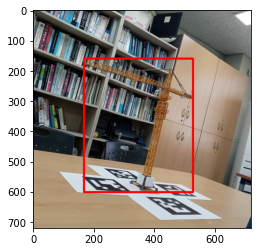

In [26]:
## Check that we can visualize boxes as Coco format:
xl = train_df.bbox[0][0]
yl = train_df.bbox[0][1]
w = train_df.bbox[0][2]
h = train_df.bbox[0][3]

fr = cv2.imread(image_dir + "/" + image_list[0])
frame_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
frame_rgb = cv2.rectangle(frame_rgb, (xl, yl), (xl+w, yl+h), (255, 0, 0), 5)
plt.imshow(frame_rgb)

### Now that conversion looks good, lets write the label files for images with boxes (positives) :

Make a folder where the data will be saved to. For some version of YOLO, all the training iamges and label files are in the same directory. So we can create a directory with all the text files with the lables in the same place. 

In [27]:
print("We have {} unique images with boxes.".format(len(train_df.image_id.unique())))
unique_img_ids = train_df.image_id.unique()

We have 67 unique images with boxes.


In [28]:
if not os.path.exists(image_dir):
    os.makedirs(imaeg_dir)

In [29]:
folder_location = path
#change  unique_img_ids[:2] to unique_img_ids to iterate through all images
for img_id in unique_img_ids: # loop through all unique image ids. Remove the slice to do all images
    print(img_id)
    filt_df = train_df.query("image_id == @img_id") # filter the df to a specific id
    #print(filt_df.shape[0])
    all_boxes = filt_df.yolo_box.values
    file_name = "{}/bbox_yolo/{}.txt".format(folder_location,img_id) # specify the name of the folder and get a file name

    s = "0 %s %s %s %s \n" # the first number is the identifier of the class. If you are doing multi-class, make sure to change that
    with open(file_name, 'a') as file: # append lines to file
        for i in all_boxes:
            new_line = (s % tuple(i))
            file.write(new_line)

creal_0001
creal_0002
creal_0003
creal_0004
creal_0005
creal_0006
creal_0007
creal_0008
creal_0009
creal_0010
creal_0011
creal_0012
creal_0013
creal_0014
creal_0015
creal_0016
creal_0017
creal_0018
creal_0019
creal_0020
creal_0021
creal_0022
creal_0023
creal_0024
creal_0025
creal_0026
creal_0027
creal_0028
creal_0029
creal_0030
creal_0031
creal_0032
creal_0033
creal_0034
creal_0035
creal_0036
creal_0037
creal_0038
creal_0039
creal_0040
creal_0041
creal_0042
creal_0043
creal_0044
creal_0045
creal_0046
creal_0047
creal_0048
creal_0049
creal_0050
creal_0051
creal_0052
creal_0053
creal_0054
creal_0055
creal_0056
creal_0057
creal_0058
creal_0059
creal_0060
creal_0061
creal_0062
creal_0063
creal_0064
creal_0065
creal_0066
creal_0067
